# Laboratorium 2

# Narzędzie

### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Przykłady użycia

##### Proste rysowanie

Rysowanie prostego rysunku złożonego ze statycznych punktów i odcinków jest stosunkowo proste. Należy utworzyć zmienną z obiektem `Plot`, który przyjmuje w konstruktorze listę obiektów `PointsCollection` jako parametr `points` oraz listę `LinesCollection` jako parametr `lines`. Następnie należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


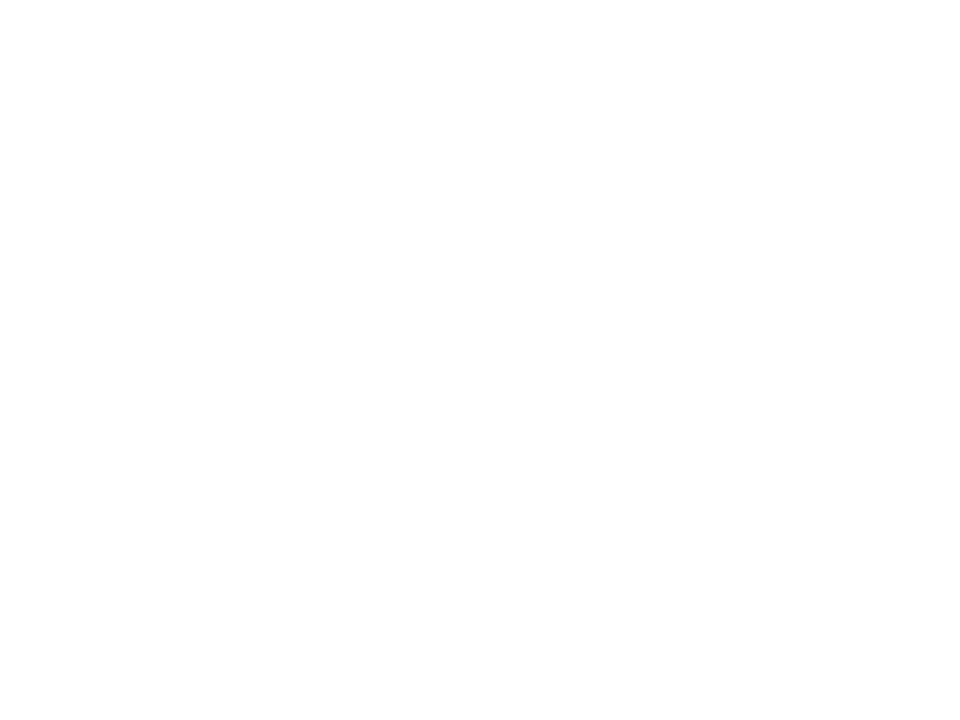

In [3]:
%matplotlib notebook

plot = Plot(points=[PointsCollection([(1, 2), (3, 1.5), (2, -1)]),
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")],
            lines=[LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])])
plot.draw()

##### Rysunek dynamiczny

To narzędzie pozwala na wizualizację "rysunków dynamicznych", a więc takich, które składają się z wielu różnych obrazów. Może to być przydatne np. podczas wizualizacji kolejnych kroków danego algorytmu. Poszczególne klatki określane są jako obiekty `Scene`, które przyjmują listę `PointsCollection` oraz listę `LinesCollection` w swoim konstruktorze. Obiekt `Plot` przyjmuje w parametrze konstruktora `scenes` właśnie listę takich scen.

Na rysunku przyciski `Następny` i `Poprzedni` służą do nawigacji pomiędzy nimi.

<IPython.core.display.Javascript object>


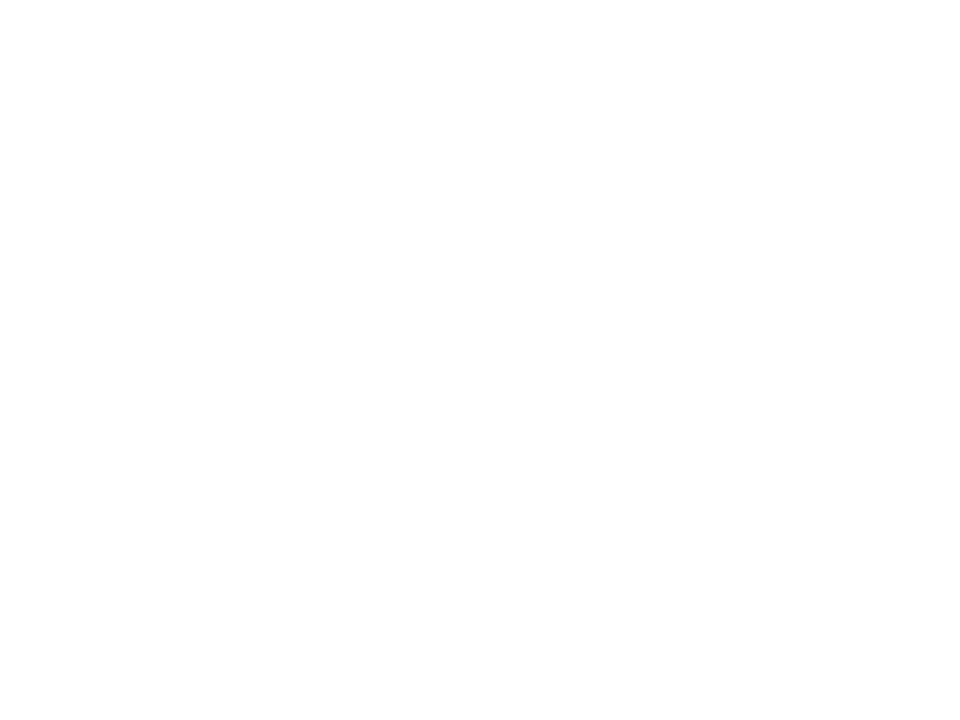

In [4]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot=Plot(scenes = scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


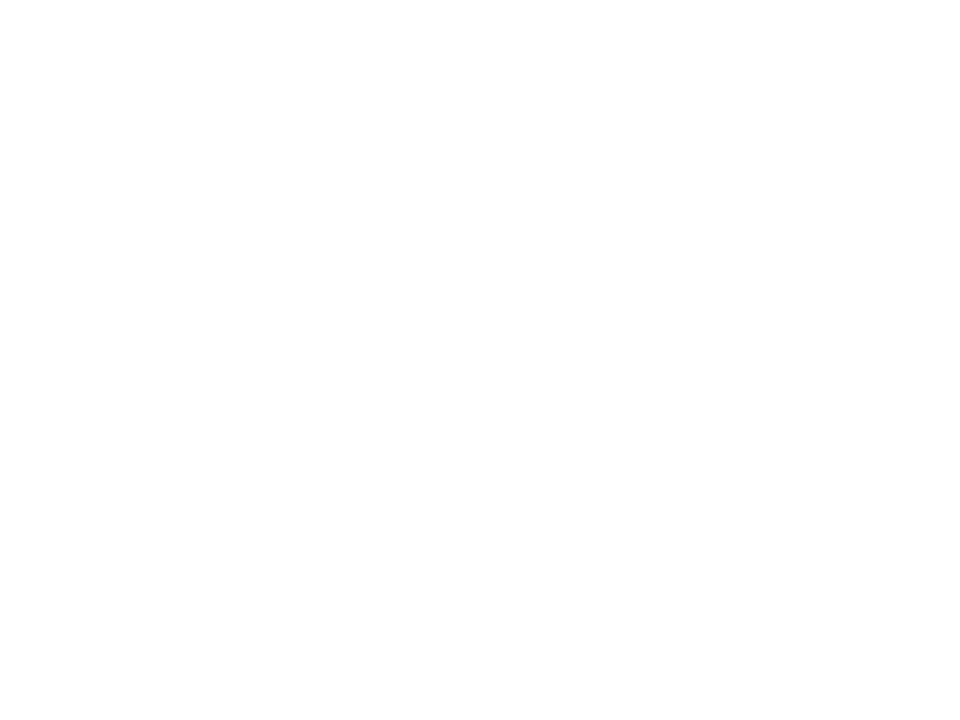

In [5]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.json: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


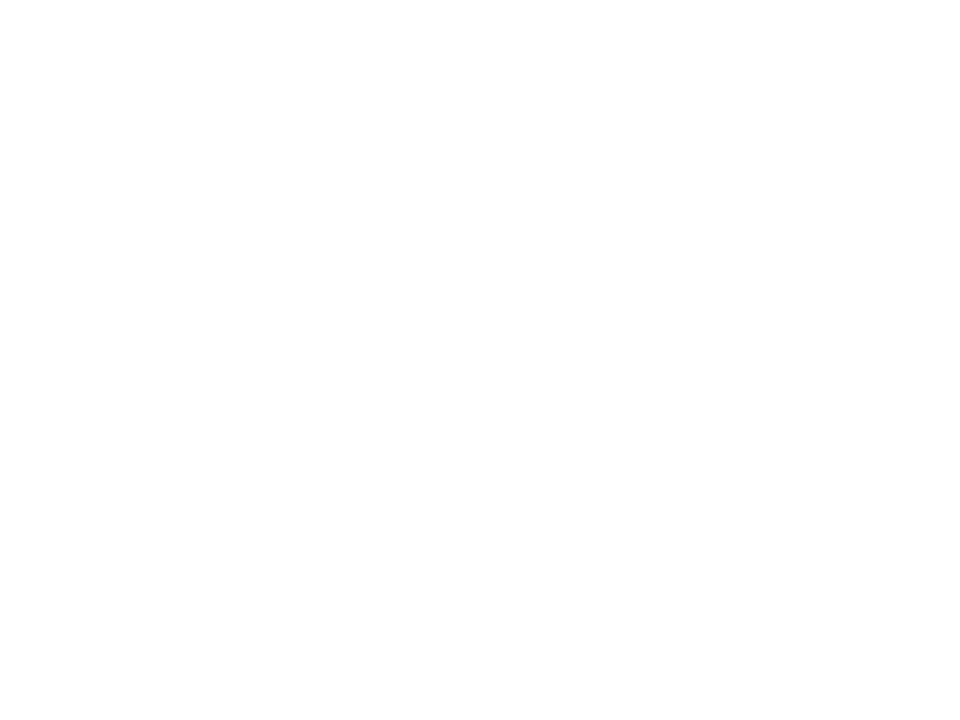

In [6]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


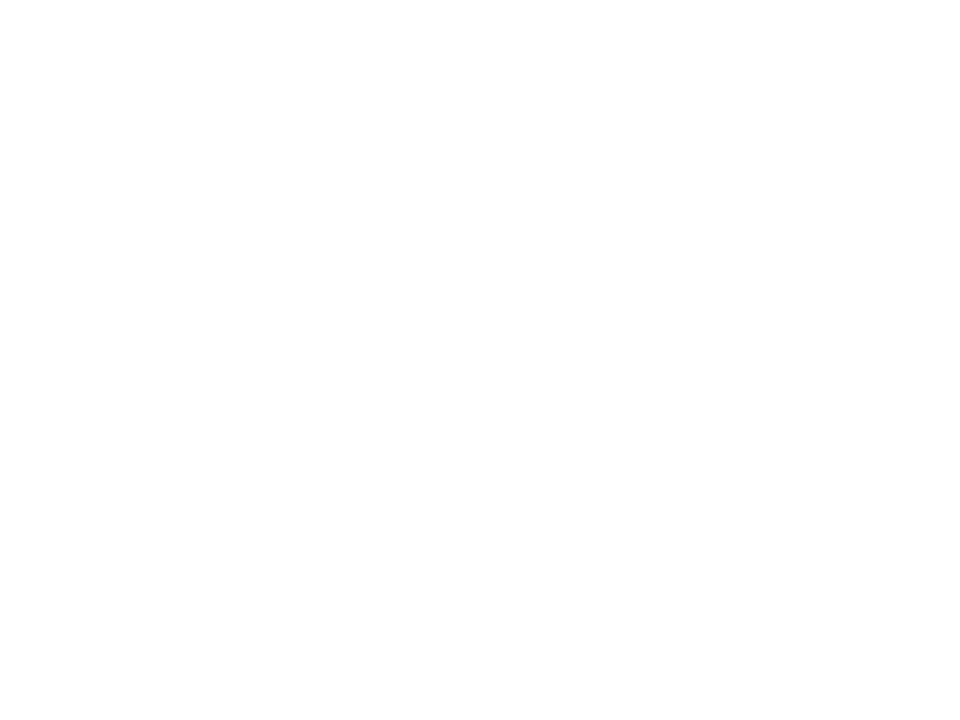

In [7]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Rozwiązanie

In [8]:
%matplotlib notebook

# Algorytmy geometryczne – ćwiczenie 2 – otoczka wypukła

In [9]:
%matplotlib notebook
import random
import math
import time

3. Zmodyfikuj program z punktu 1 tak, aby możliwe było zadawanie określonych parametrów dla schematów losowania punktów podanych powyżej:
+ a) liczba punktów, przedziały dla współrzędnych,
+ b) liczba punktów, środek i promień okręgu,
+ c) liczba punktów, wierzchołki prostokąta,
+ d) wierzchołki kwadratu, liczba punktów na osiach, liczba punktów na przekątnych.

In [146]:
EPSILON = 10 ** -12

A_NUM = 100
A_MIN_RNG = -100
A_MAX_RNG = 100

B_NUM = 100
B_RADIUS = 10
B_CENTER = (0, 0)

C_NUM = 100
C_V_1 = (-10, 10)
C_V_2 = (-10, -10)
C_V_3 = (10, -10)
C_V_4 = (10, 10)

D_NUM_SIDE = 25
D_NUM_DIAGONAL = 20
D_V_1 = (0, 0)
D_V_2 = (10, 0)
D_V_3 = (10, 10)
D_V_4 = (0, 10)

1. Przygotuj program generujący następujące zbiory punktów na płaszczyźnie (współrzędne rzeczywiste typu double):

+ a) zawierający 100 losowo wygenerowanych punktów o współrzędnych z przedziału [-100, 100],
+ b) zawierający 100 losowo wygenerowanych punktów leżących na okręgu o środku (0,0) i promieniu R=10,
+ c) zawierający 100 losowo wygenerowanych punktów leżących na bokach prostokąta o wierzchołkach (-10, 10), (-10,-10), (10,-10), (10,10),
+ d) zawierający wierzchołki kwadratu (0, 0), (10, 0), (10, 10), (0, 10) oraz punkty wygenerowane losowo w sposób następujący: po 25 punktów na dwóch bokach kwadratu leżących na osiach i po 20 punktów na przekątnych kwadratu.

2. Uruchom wizualizację graficzną utworzonych zbiorów punktów.

In [11]:
## Zbiór A

<IPython.core.display.Javascript object>


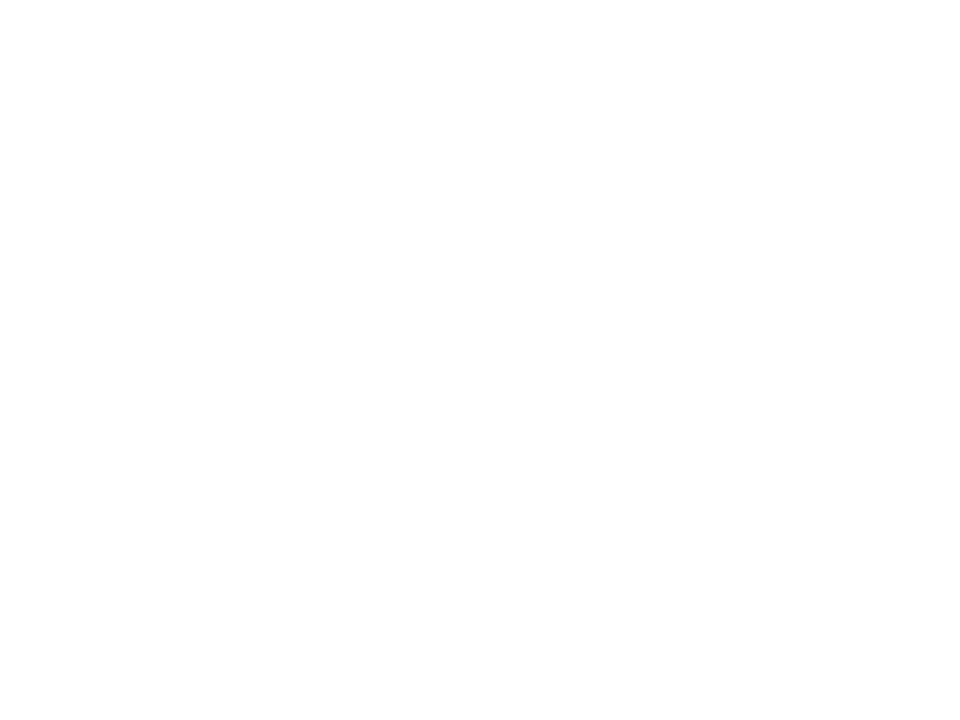

In [12]:
def gen_set_a():
    set_a = [(random.uniform(A_MIN_RNG, A_MAX_RNG), random.uniform(A_MIN_RNG, A_MAX_RNG)) for _ in range(A_NUM)]
    return set_a

set_a = gen_set_a()
plot = Plot(points=[PointsCollection(set_a)])
plot.draw()

In [13]:
## Zbiór B

<IPython.core.display.Javascript object>


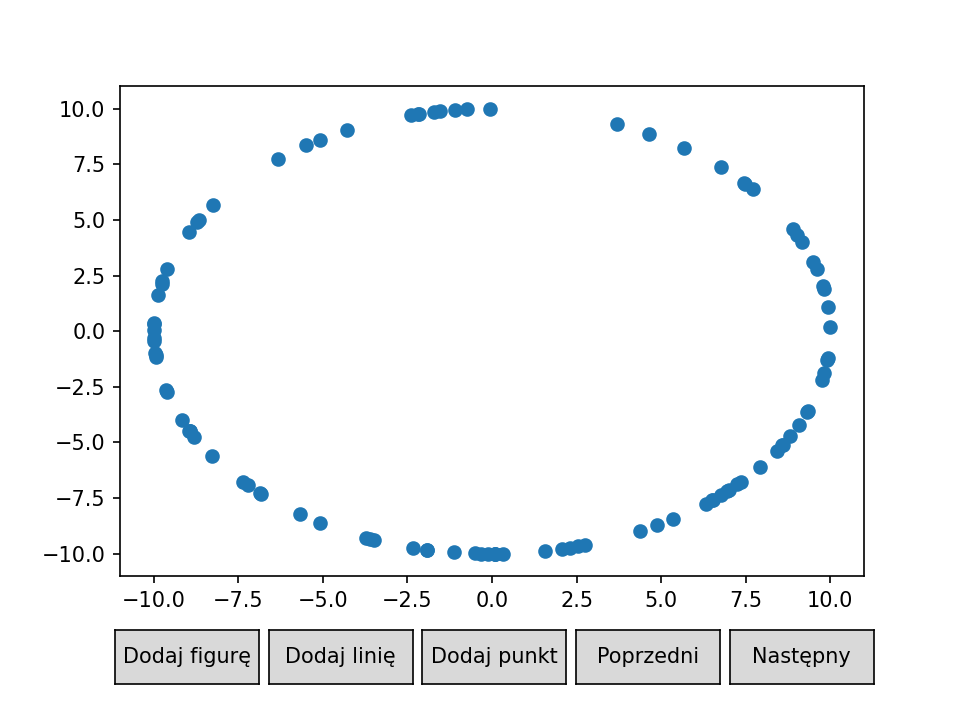

In [147]:
def gen_set_b():
    set_b = []

    for _ in range(B_NUM):
        t = random.uniform(0, 2*math.pi)
        x = B_RADIUS * math.sin(t) + B_CENTER[0]
        y = B_RADIUS * math.cos(t) + B_CENTER[1]

        set_b.append((x, y))
    
    return set_b

set_b = gen_set_b()
plot = Plot(points=[PointsCollection(set_b)])
plot.draw()

## Zbiór C

<IPython.core.display.Javascript object>


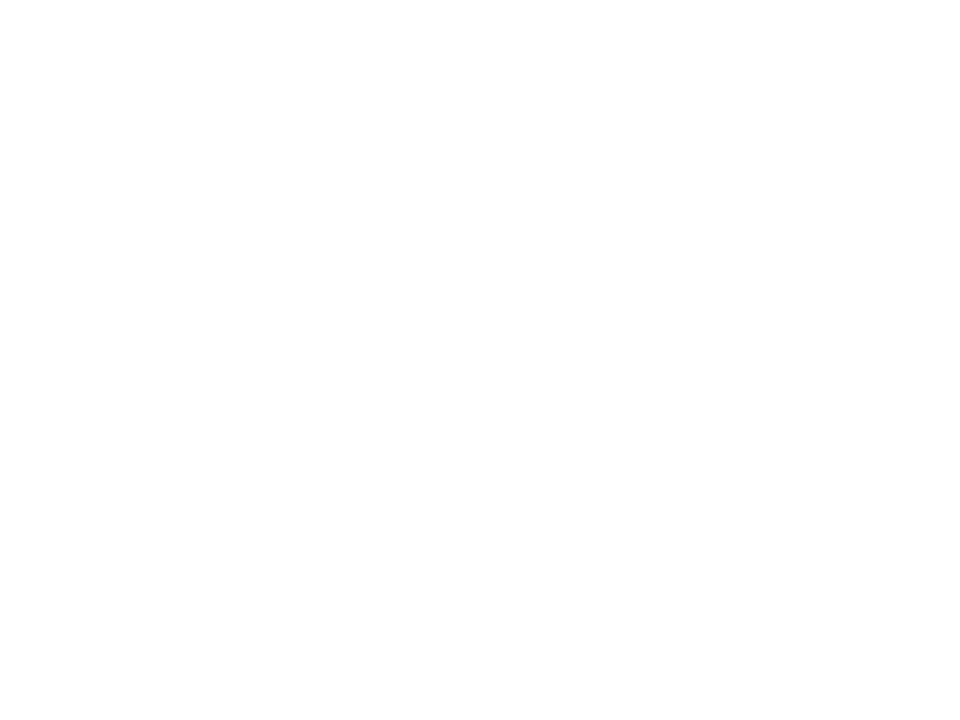

In [15]:
corners_c = [C_V_1, C_V_2, C_V_3, C_V_4]

def gen_set_c():
    set_c = [C_V_1, C_V_2, C_V_3, C_V_4]

    for _ in range(C_NUM):
        side = random.choice((1,2,3,4))

        if side == 1:
            x = random.uniform(C_V_1[0], C_V_2[0])
            y = random.uniform(C_V_1[1], C_V_2[1])
        elif side == 2:
            x = random.uniform(C_V_2[0], C_V_3[0])
            y = random.uniform(C_V_2[1], C_V_3[1])
        elif side == 3:
            x = random.uniform(C_V_3[0], C_V_4[0])
            y = random.uniform(C_V_3[1], C_V_4[1])
        elif side == 4:
            x = random.uniform(C_V_4[0], C_V_1[0])
            y = random.uniform(C_V_4[1], C_V_1[1])

        set_c.append((x, y))
        
    return set_c

set_c = gen_set_c()
plot = Plot(points=[PointsCollection(set_c),
                   PointsCollection(corners_c, color="orange")])
plot.draw()

## Zbiór D

<IPython.core.display.Javascript object>


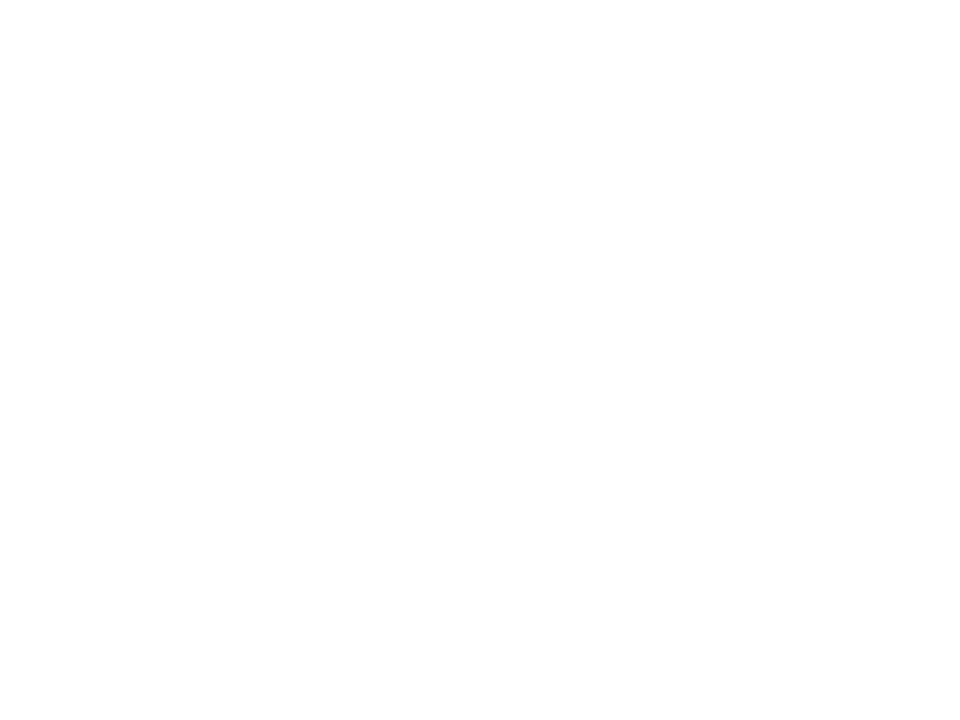

In [16]:
corners_d = [D_V_1, D_V_2, D_V_3, D_V_4]

def gen_set_d():
    set_d = [D_V_1, D_V_2, D_V_3, D_V_4]

    for _ in range(D_NUM_SIDE):
        x = random.uniform(D_V_1[0], D_V_2[0])
        y = D_V_1[1]
        set_d.append((x, y))

    for _ in range(D_NUM_SIDE):
        x = D_V_1[0]
        y = random.uniform(D_V_1[1], D_V_4[1])
        set_d.append((x, y))

    for _ in range(D_NUM_DIAGONAL):
        x = random.uniform(D_V_1[0], D_V_2[0])
        y = x + D_V_1[1]
        set_d.append((x, y))

    for _ in range(D_NUM_DIAGONAL):
        x = random.uniform(D_V_1[0], D_V_2[0])
        y = -x + D_V_3[1]
        set_d.append((x, y))
        
    return set_d

set_d = gen_set_d()
plot = Plot(points=[PointsCollection(set_d),
                   PointsCollection(corners_d, color="orange")])
plot.draw()

## Algorytmy pomocnicze

In [17]:
#Euclidean distance
def distance(a, b):
    #return math.sqrt((b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2)
    return (b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2

In [18]:
def det(a, b, c, epsilon = EPSILON):
    return (a[0]*b[1] + b[0]*c[1] + c[0]*a[1] - b[1]*c[0] - c[1]*a[0] - a[1]*b[0])

In [19]:
def orient(a, b, c, epsilon = EPSILON):
    determinant = det(a, b, c, epsilon)
    
    if determinant > EPSILON:
        return 1
    elif determinant < -EPSILON:
        return -1
    else:
        return 0

In [20]:
def min_left(points):
     return min(points, key = lambda x: (x[1], x[0]))

In [21]:
def partition(points, x, left, right):
    i = left - 1     
    pivot = points[right]    
 
    for j in range(left, right):
        if orient(x, points[j], pivot) == 1 or ( orient(x, points[j], pivot) == 0 and distance(x, points[j]) > distance(x, pivot) ):
            i += 1
            points[i], points[j] = points[j], points[i]
            
    points[i+1], points[right] = points[right], points[i+1]
    
    return i+1

In [22]:
def quick_sort(points, x, left, right):
    if left < right:
        pivot = partition(points, x, left, right)
        quick_sort(points, x, left, pivot - 1)
        quick_sort(points, x, pivot + 1, right)

## Algorytm Grahama

In [23]:
 def graham(points_set, save = False, epsilon = EPSILON):
    points = points_set.copy()
    
    if len(points) < 3:
        return
    
    scenes = []
    start_point = min_left(points)
    points.remove(start_point)
    quick_sort(points, start_point, 0, len(points) - 1)
    hull = [start_point, points[0], points[1]]

    i = 3
    while i < len(points):
        scenes.append(Scene([PointsCollection(points, color="deepskyblue"),
                             PointsCollection(hull.copy(), color="red"), 
                             PointsCollection([points[i]], color="green")],
                            [LinesCollection([(hull[i], hull[i+1]) for i in range(len(hull)-1)], color="red"),
                             LinesCollection([(points[i], hull[-1])], color="green")])) 
        
        if orient(hull[-2], hull[-1], points[i]) == 0:
            hull.pop()
            hull.append(points[i])
            i += 1
        elif orient(hull[-2], hull[-1], points[i]) == 1:
            hull.append(points[i])
            i += 1
        else:
            hull.pop()

    if orient(hull[-2], hull[-1], start_point) == 0:
        hull.pop()

    final_scene = Scene([PointsCollection(points, color="deepskyblue"), PointsCollection(hull, color="red")], [LinesCollection([(hull[i-1], hull[i]) for i in range(len(hull))], color="red")])
    scenes = [final_scene] + scenes
   
    if save:
        with open("graham.txt", 'w') as file:
            for step in hull:
                file.write(f"{step}\n")
                
    return scenes

In [24]:
 def graham_time(points_set, epsilon = EPSILON):
    points = points_set.copy()
    
    if len(points) < 3:
        return
    
    scenes = []
    start_point = min_left(points)
    points.remove(start_point)
    quick_sort(points, start_point, 0, len(points) - 1)
    hull = [start_point, points[0], points[1]]

    i = 3
    while i < len(points):
        if orient(hull[-2], hull[-1], points[i]) == 0:
            hull.pop()
            hull.append(points[i])
            i += 1
        elif orient(hull[-2], hull[-1], points[i]) == 1:
            hull.append(points[i])
            i += 1
        else:
            hull.pop()

    if orient(hull[-2], hull[-1], start_point) == 0:
        hull.pop()
                
    return scenes

## Algorytm Jarvisa

In [89]:
def jarvis(points, epsilon = EPSILON): 
    scenes = []
    hull = [] 
    
    start_point = min(points, key = lambda x: (x[1], x[0]))
    hull_point = start_point
    end_point = points[0]
    
    while True: 
        hull.append(hull_point) 
        end_point = points[0]
        
        for i in range(len(points)): 
            scenes.append(Scene([PointsCollection(points, color="deepskyblue"),
                             PointsCollection(hull.copy(), color="red"), 
                             PointsCollection([points[i]], color="green")],
                            [LinesCollection([(hull[i], hull[i+1]) for i in range(len(hull)-1)], color="red"),
                             LinesCollection([(points[i], hull[-1])], color="green")])) 
            
            if (orient(hull_point, end_point, points[i]) == 1) or orient(hull_point, points[i], end_point) == 0 and distance(hull_point, points[i]) > distance(hull_point, end_point): 
                end_point = points[i] 

        hull_point = end_point 
  
        if hull_point == start_point: 
            break
            
    lines = [(hull[i], hull[i+1]) for i in range(len(hull)-1)]
    lines.append([hull[-1], hull[0]])
    
    final_scene = Scene([PointsCollection(points, color="deepskyblue"),
                         PointsCollection(hull, color="red")],
                        [LinesCollection([(hull[i-1], hull[i]) for i in range(len(hull))], color="red")])
    scenes = [final_scene] + scenes
  
    return scenes

In [ ]:
def jarvis_time(points, epsilon = EPSILON): 
    scenes = []
    hull = [] 
    
    start_point = min(points, key = lambda x: (x[1], x[0]))
    hull_point = start_point
    end_point = points[0]
    
    while True: 
        hull.append(hull_point) 
        end_point = points[0]
        
        for i in range(len(points)): 
            if (orient(hull_point, end_point, points[i]) == 1) or orient(hull_point, points[i], end_point) == 0 and distance(hull_point, points[i]) > distance(hull_point, end_point): 
                end_point = points[i] 

        hull_point = end_point 
  
        if hull_point == start_point: 
            break
            
    return scenes

5. W sprawozdaniu napisz, czy Twój program działał poprawnie dla wszystkich zbiorów danych oraz opisz krótko wnioski dotyczące działania algorytmu dla poszczególnych zbiorów. Napisz, dlaczego wg Ciebie zaproponowano takie zbiory punktów? Które ze zbiorów mogły stwarzać problemy w działaniu algorytmów? Jeśli tak, to jakie i dlaczego? Porównaj czasy działania obu algorytmów w zależności od liczby punktów w poszczególnych zbiorach (a, b, c, d). Dołącz wybrane, istotne ilustracje.

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


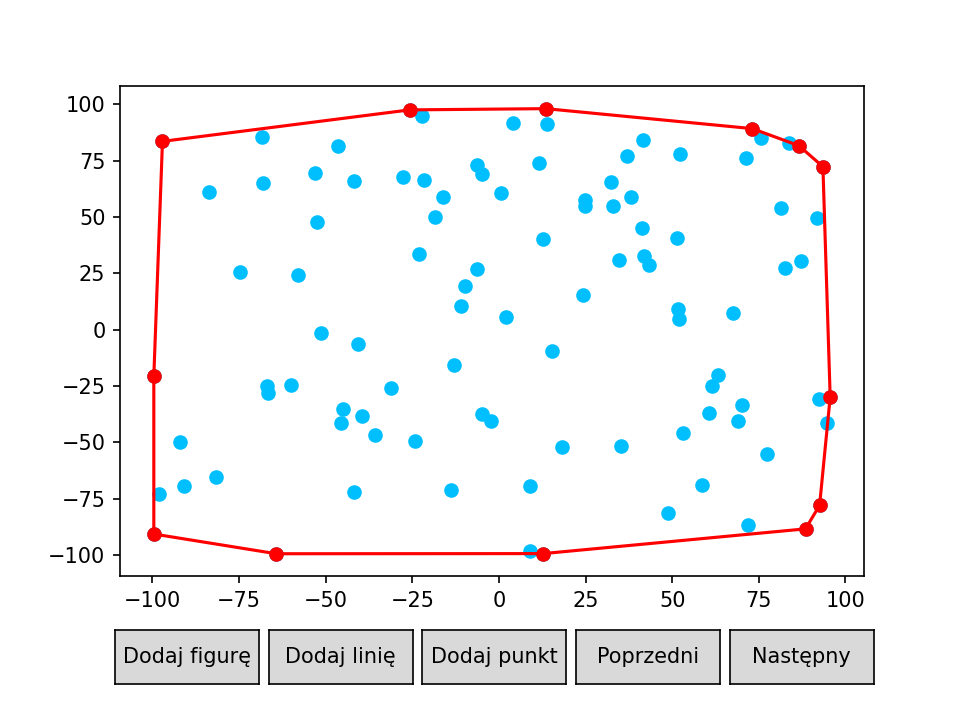

In [88]:
%matplotlib

hull = jarvis(set_a)
plot=Plot(scenes = hull)
plot.draw()

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


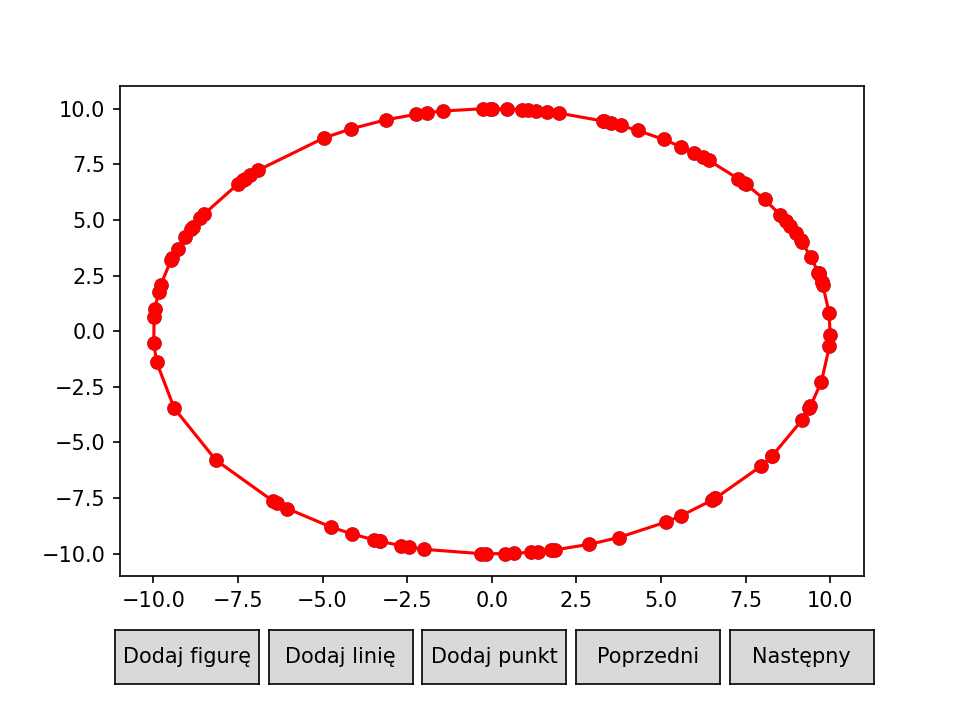

In [142]:
%matplotlib

hull = jarvis(set_b)
plot=Plot(scenes = hull)
plot.draw()

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


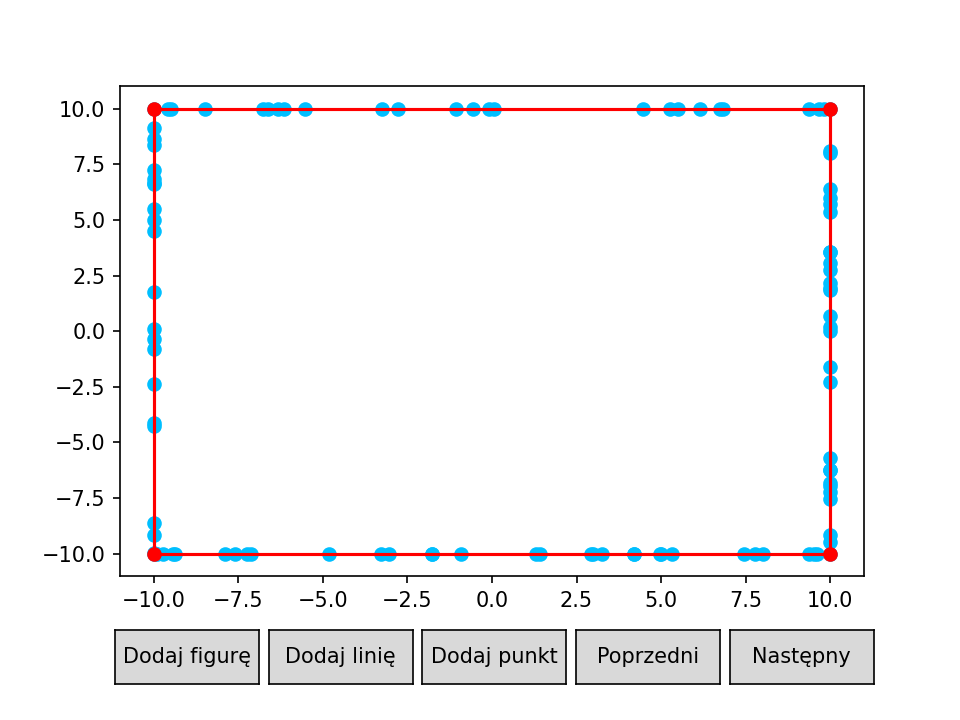

In [92]:
%matplotlib

hull = jarvis(set_c)
plot = Plot(scenes=hull)
plot.draw()

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


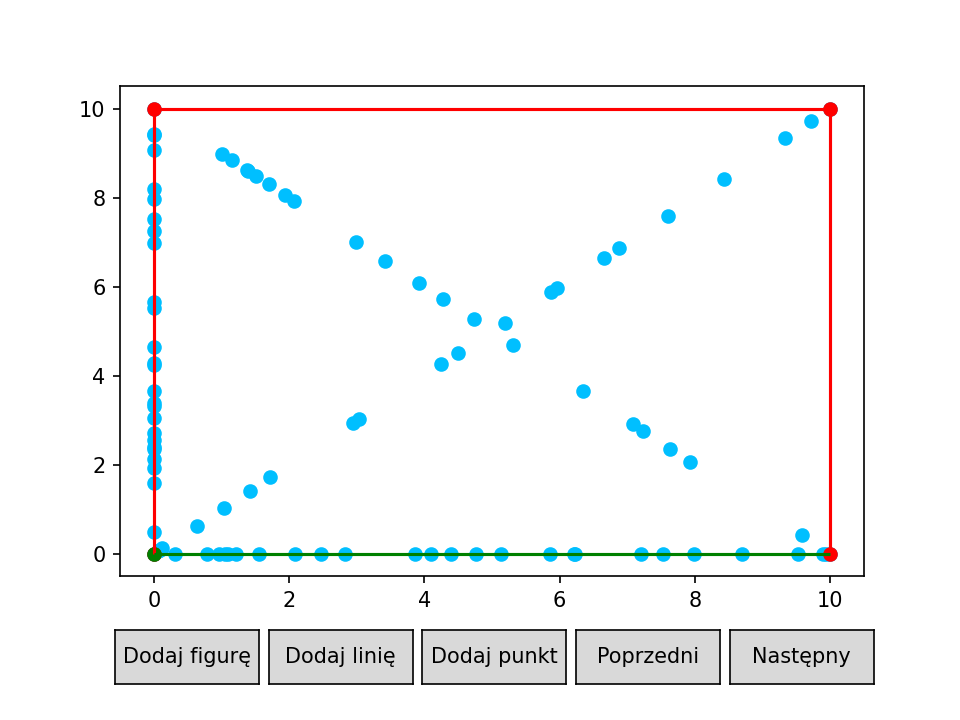

In [152]:
%matplotlib

hull = jarvis(set_d)
plot = Plot(scenes=hull)
plot.draw()

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


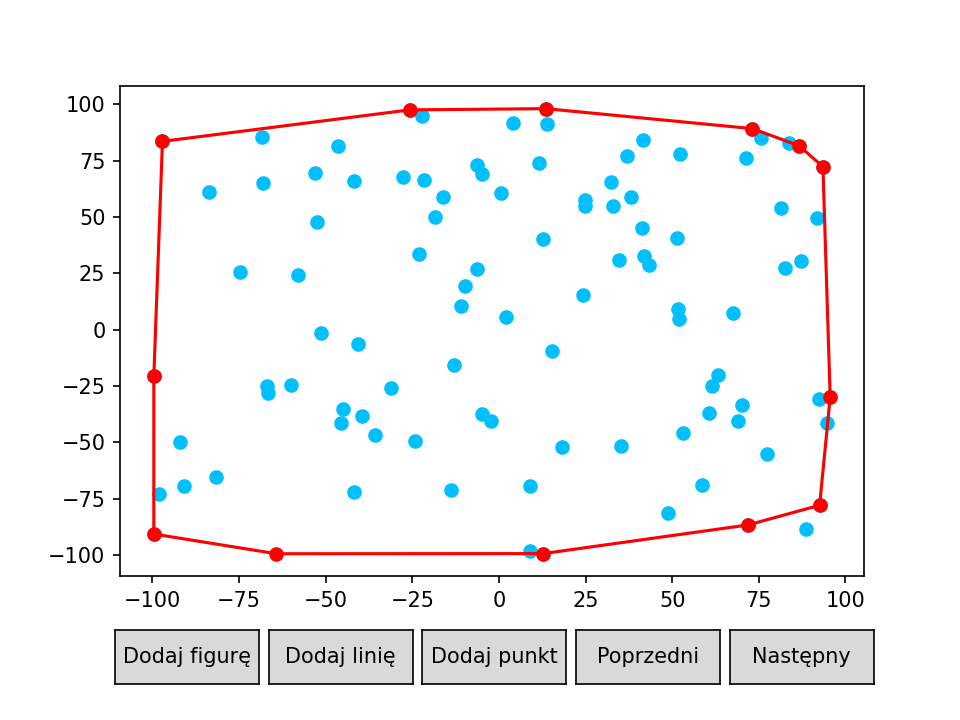

In [95]:
%matplotlib

hull = graham(set_a)
plot = Plot(scenes=hull)
plot.draw()

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


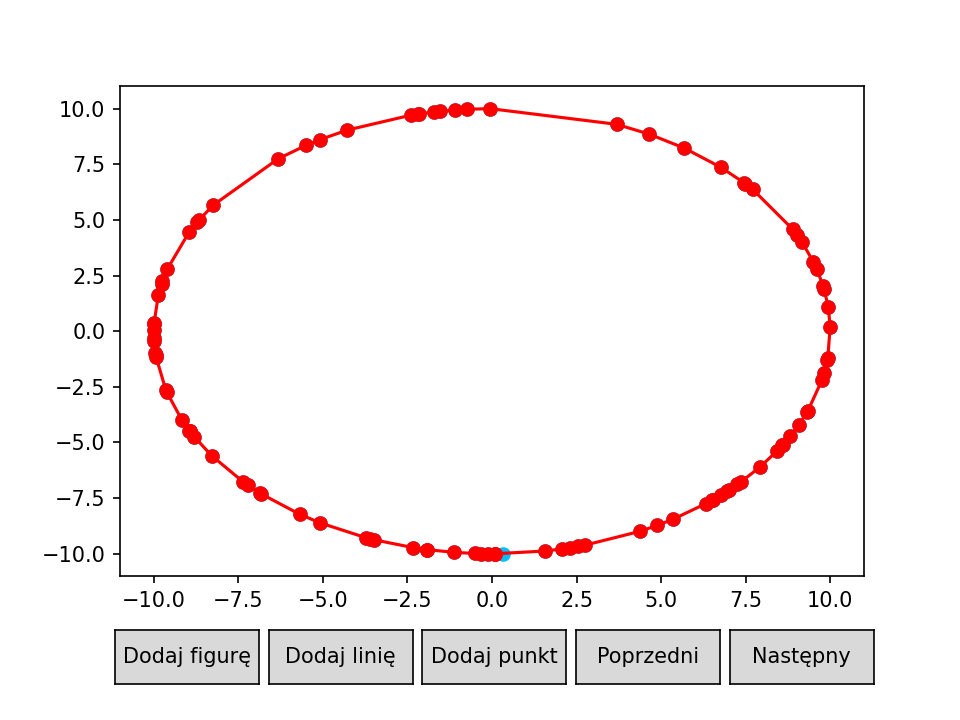

In [149]:
%matplotlib

hull = graham(set_b)
plot = Plot(scenes=hull)
plot.draw()

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


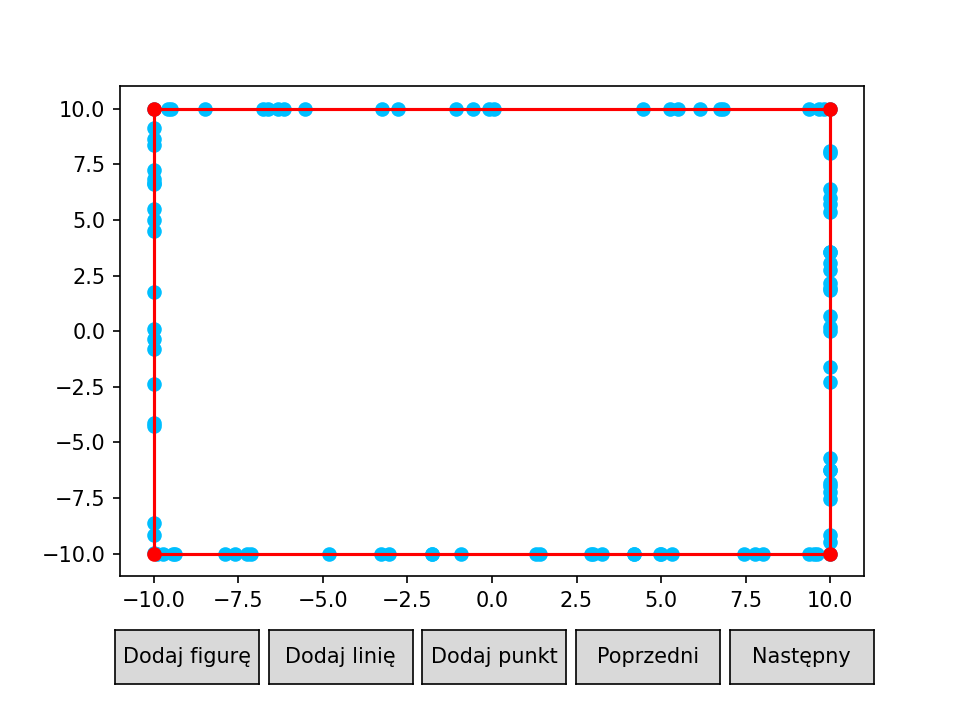

In [97]:
%matplotlib

hull = graham(set_c)
plot = Plot(scenes=hull)
plot.draw()

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


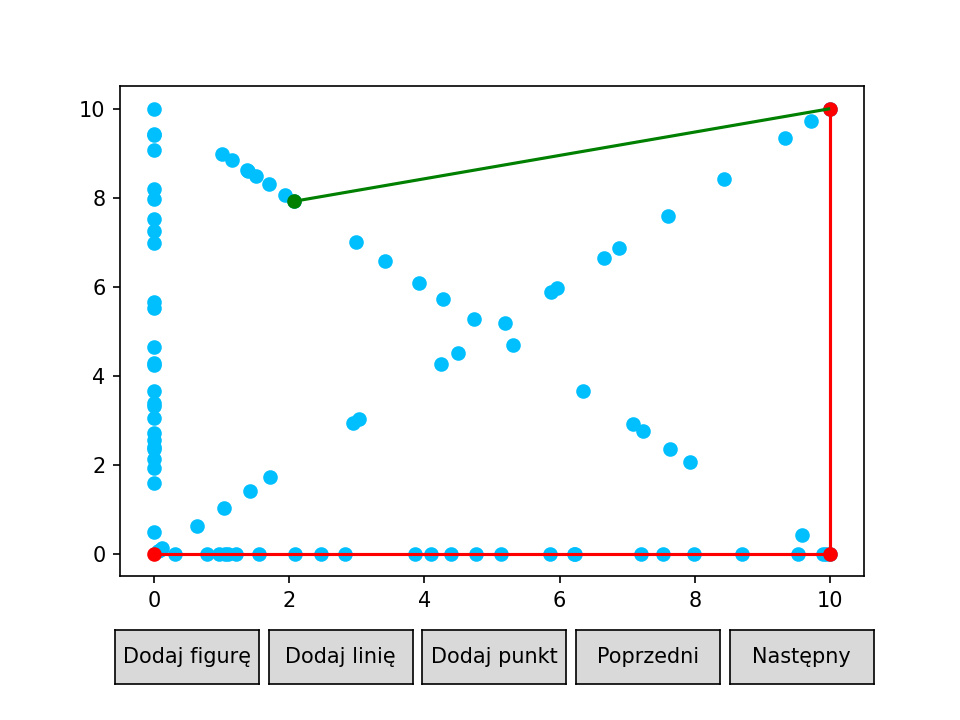

In [150]:
%matplotlib

hull = graham(set_d)
plot = Plot(scenes=hull)
plot.draw()

5. W sprawozdaniu napisz, czy Twój program działał poprawnie dla wszystkich zbiorów danych oraz opisz krótko wnioski dotyczące działania algorytmu dla poszczególnych zbiorów. Napisz, dlaczego wg Ciebie zaproponowano takie zbiory punktów? Które ze zbiorów mogły stwarzać problemy w działaniu algorytmów? Jeśli tak, to jakie i dlaczego? Porównaj czasy działania obu algorytmów w zależności od liczby punktów w poszczególnych zbiorach (a, b, c, d). Dołącz wybrane, istotne ilustracje.

In [103]:
import time

In [104]:
print("100")
A_NUM = 100

time_start = time.time()
graham_time(gen_set_a())
time_stop = time.time()
print("Graham:", time_stop-time_start)

time_start = time.time()
jarvis_time(gen_set_a())
time_stop = time.time()
print("Jarvis:", time_stop-time_start)

100
Graham: 0.0016367435455322266
Jarvis: 0.002641916275024414


In [106]:
print("1000")
A_NUM = 1000

time_start = time.time()
graham_time(gen_set_a())
time_stop = time.time()
print("Graham:", time_stop-time_start)

time_start = time.time()
jarvis_time(gen_set_a())
time_stop = time.time()
print("Jarvis:", time_stop-time_start)

1000
Graham: 0.01870894432067871
Jarvis: 0.02900409698486328


In [108]:
print("10000")
A_NUM = 10000

time_start = time.time()
jarvis_time(gen_set_a())
time_stop = time.time()
print("Graham:", time_stop-time_start)

time_start = time.time()
jarvis_time(gen_set_a())
time_stop = time.time()
print("Jarvis:", time_stop-time_start)

10000
Graham: 0.3865199089050293
Jarvis: 0.3258030414581299


In [109]:
print("100000")
A_NUM = 100000

time_start = time.time()
graham_time(gen_set_a())
time_stop = time.time()
print("Graham:", time_stop-time_start)

time_start = time.time()
jarvis_time(gen_set_a())
time_stop = time.time()
print("Jarvis:", time_stop-time_start)

100000
Graham: 2.9094629287719727
Jarvis: 3.897301197052002


In [110]:
print("100")
B_NUM = 100

time_start = time.time()
graham_time(gen_set_b())
time_stop = time.time()
print("Graham:", time_stop-time_start)

time_start = time.time()
jarvis_time(gen_set_b())
time_stop = time.time()
print("Jarvis:", time_stop-time_start)

100
Graham: 0.0013010501861572266
Jarvis: 0.015949010848999023


In [111]:
print("1000")
B_NUM = 1000

time_start = time.time()
graham_time(gen_set_b())
time_stop = time.time()
print("Graham:", time_stop-time_start)

time_start = time.time()
jarvis_time(gen_set_b())
time_stop = time.time()
print("Jarvis:", time_stop-time_start)

1000
Graham: 0.015472173690795898
Jarvis: 1.4413378238677979


In [113]:
print("2000")
B_NUM = 2000

time_start = time.time()
graham_time(gen_set_b())
time_stop = time.time()
print("Graham:", time_stop-time_start)

time_start = time.time()
jarvis_time(gen_set_b())
time_stop = time.time()
print("Jarvis:", time_stop-time_start)

2000
Graham: 0.03773379325866699
Jarvis: 5.3151140213012695


In [114]:
print("5000")
B_NUM = 5000

time_start = time.time()
graham_time(gen_set_b())
time_stop = time.time()
print("Graham:", time_stop-time_start)

time_start = time.time()
jarvis_time(gen_set_b())
time_stop = time.time()
print("Jarvis:", time_stop-time_start)

5000
Graham: 0.09313201904296875
Jarvis: 34.44943380355835


In [115]:
print("100")
C_NUM = 100

time_start = time.time()
graham_time(gen_set_c())
time_stop = time.time()
print("Graham:", time_stop-time_start)

time_start = time.time()
jarvis_time(gen_set_c())
time_stop = time.time()
print("Jarvis:", time_stop-time_start)

100
Graham: 0.0016570091247558594
Jarvis: 0.0009918212890625


In [116]:
print("1000")
C_NUM = 1000

time_start = time.time()
graham_time(gen_set_c())
time_stop = time.time()
print("Graham:", time_stop-time_start)

time_start = time.time()
jarvis_time(gen_set_c())
time_stop = time.time()
print("Jarvis:", time_stop-time_start)

1000
Graham: 0.025387048721313477
Jarvis: 0.010053873062133789


In [117]:
print("5000")
C_NUM = 5000

time_start = time.time()
graham_time(gen_set_c())
time_stop = time.time()
print("Graham:", time_stop-time_start)

time_start = time.time()
jarvis_time(gen_set_c())
time_stop = time.time()
print("Jarvis:", time_stop-time_start)

5000
Graham: 0.13649678230285645
Jarvis: 0.04505801200866699


In [118]:
print("10000")
C_NUM = 10000

time_start = time.time()
graham_time(gen_set_c())
time_stop = time.time()
print("Graham:", time_stop-time_start)

time_start = time.time()
jarvis_time(gen_set_c())
time_stop = time.time()
print("Jarvis:", time_stop-time_start)

10000
Graham: 0.2875039577484131
Jarvis: 0.0908498764038086


In [119]:
print("(25, 20)")
D_NUM_SIDE = 25
D_NUM_DIAGONAL = 20

time_start = time.time()
graham_time(gen_set_d())
time_stop = time.time()
print("Graham:", time_stop-time_start)

time_start = time.time()
jarvis_time(gen_set_d())
time_stop = time.time()
print("Jarvis:", time_stop-time_start)

(25, 20)
Graham: 0.0028328895568847656
Jarvis: 0.001965045928955078


In [120]:
print("(50, 40)")
D_NUM_SIDE = 50
D_NUM_DIAGONAL = 40

time_start = time.time()
graham_time(gen_set_d())
time_stop = time.time()
print("Graham:", time_stop-time_start)

time_start = time.time()
jarvis_time(gen_set_d())
time_stop = time.time()
print("Jarvis:", time_stop-time_start)

(50, 40)
Graham: 0.003509998321533203
Jarvis: 0.0014820098876953125


In [121]:
print("(25000, 20000)")
D_NUM_SIDE = 25000
D_NUM_DIAGONAL = 20000

time_start = time.time()
graham_time(gen_set_d())
time_stop = time.time()
print("Graham:", time_stop-time_start)

time_start = time.time()
jarvis_time(gen_set_d())
time_stop = time.time()
print("Jarvis:", time_stop-time_start)

(25000, 20000)
Graham: 4.1842100620269775
Jarvis: 0.6846508979797363


In [134]:
print("(50000, 40000)")
D_NUM_SIDE = 50000
D_NUM_DIAGONAL = 40000

time_start = time.time()
graham_time(gen_set_d())
time_stop = time.time()
print("Graham:", time_stop-time_start)

time_start = time.time()
jarvis_time(gen_set_d())
time_stop = time.time()
print("Jarvis:", time_stop-time_start)

(50000, 40000)
Graham: 8.628615856170654
Jarvis: 1.3240010738372803
